In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from concurrent.futures import ThreadPoolExecutor

import wandb
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import torch
from torch.utils.flop_counter import FlopCounterMode

from sklearn.model_selection import cross_validate, train_test_split, KFold
from scipy.stats import pearsonr

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from convnext_scaling.models.regnet import RegNetModule
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_theme(context="talk", style="whitegrid")

ModuleNotFoundError: No module named 'seaborn'

In [5]:
onnx = pd.read_csv("./design_space_results/space_a/results_onnx_windesktop.csv", index_col=0)
onnx["partition"] = "onnx"

m4pro = pd.read_csv("./design_space_results/space_a/results_m4pro_mps.csv", index_col=0)
m4pro["partition"] = "M4"

dml = pd.read_csv("./design_space_results/space_a/results_onnx_windesktop.csv", index_col=0)
dml.rename(columns={"time_DmlExecutionProvider": "time"}, inplace=True)
dml["partition"] = "Desktop$_{DML}$"
dml["nparams"] = m4pro.nparams
dml["nflops"] = m4pro.nflops

ti3070 = pd.read_csv("./design_space_results/space_a/results_onnx_3070ti.csv", index_col=0)
ti3070.rename(columns={"time_CUDAExecutionProvider": "time"}, inplace=True)
ti3070["partition"] = "Desktop$_{cuda}$"
ti3070["nparams"] = m4pro.nparams
ti3070["nflops"] = m4pro.nflops

intel = pd.read_csv("./design_space_results/space_a/results_ov_intel.csv", index_col=0)
intel["nparams"] = m4pro.nparams
intel["nflops"] = m4pro.nflops

intel = intel.rename(columns=lambda x: x.replace("time_", "")).melt(id_vars=["nparams", "nflops"], var_name="partition", value_name="time", ignore_index=False)

runtime = pd.concat([intel, m4pro, dml, ti3070])

order = list(runtime.groupby("partition").time.median().sort_values().index)



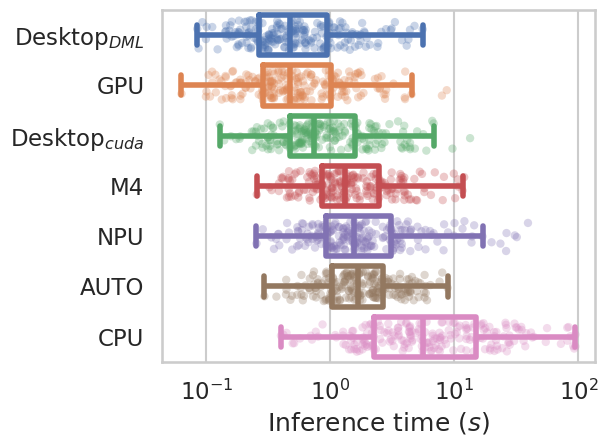

In [6]:
sns.boxplot(runtime, y="partition", x="time", zorder=1, fliersize=0, hue="partition", fill=False, log_scale=True, order=order, hue_order=order, linewidth=4)
sns.stripplot(runtime, y="partition", x="time", zorder=2, hue="partition", alpha=0.3, jitter=0.3, order=order, hue_order=order, s=6, log_scale=True)
plt.xscale("log")
plt.xlabel("Inference time $(s)$")
plt.ylabel("")
plt.tight_layout()
plt.savefig("./design_space_results/space_a/runtime_box.png", dpi=300)
plt.show()

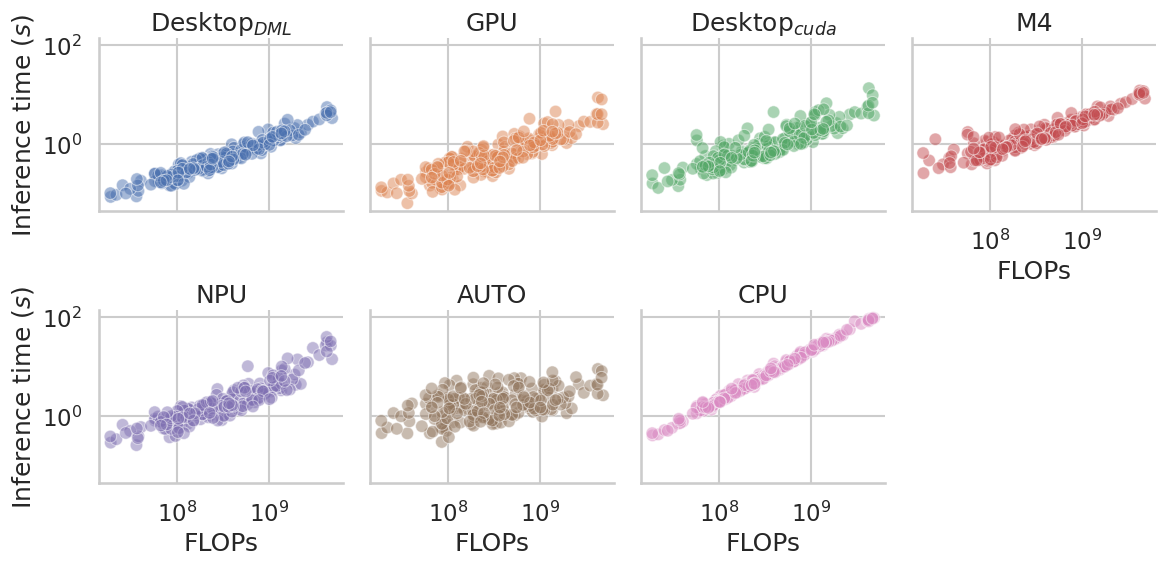

In [321]:
g = sns.FacetGrid(runtime, col="partition", col_order=order, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="nflops", y="time", hue="partition", alpha=0.5, hue_order=order)
g.set(xscale="log", yscale="log", ylabel="Inference time $(s)$", xlabel="FLOPs")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.savefig("./design_space_results/space_a/runtime_vs_flops.png", dpi=300)

In [7]:
METRICS = ["PhysioAccuracy", "AUPRC", "AUROC", "F1", "Recall", "Precision"]
HYPER_PARAMS = [
    "depth",
    "w_init",
    "w_0",
    "w_a",
    "w_m",
    "group_width",
    "bottleneck_multiplier",
    "se_ratio",
    "init_kernel_size",
    "init_lr",
    "nparams",
    "flops",
    "stages",
    "fc_features",
    "last_conv_channels",
]

MODEL_PARAMS = [
    "depth",
    "w_init",
    "w_0",
    "w_a",
    "w_m",
    "group_width",
    "bottleneck_multiplier",
    "se_ratio",
    "init_kernel_size",
]


In [8]:
def count_params(m):
    return sum(x.numel() for x in m.parameters() if x.requires_grad)

def get_flops(model, with_backward=False):
    inp = torch.rand(1, 12, 1024)
    istrain = model.training
    model.eval()

    flop_counter = FlopCounterMode(display=False, depth=None)
    with flop_counter:
        if with_backward:
            model(inp).sum().backward()
        else:
            model(inp)
    total_flops = flop_counter.get_total_flops()

    if istrain:
        model.train()
    return total_flops

def get_model_meta(config):
    model = RegNetModule(**{key: config[key] for key in MODEL_PARAMS})
    return {
        "nparams": count_params(model),
        "flops": get_flops(model),
        "stages": len(model.model.trunk_output),
        "fc_features": model.model.fc.in_features,
        "last_conv_channels": model.model.trunk_output[-1][-1].f.c[0].in_channels
    }

def extract_run_data(run):
    """ Extracts only serializable data to avoid multiprocessing issues. """
    return {
        "config": run.config,
        "history": run.history().max().to_dict()
    }

def get_run_meta(run_data):
    """ Computes model meta given extracted run data. """
    config = run_data["config"]
    history = run_data["history"]
    model_meta = get_model_meta(config)
    return {**config, **history, **model_meta}

def runs_to_df(max_workers=None):
    """ Fetch all runs and process them in parallel. """
    api = wandb.Api()
    runs = api.runs("PhysioNetDesignSpace")

    # Extract serializable run data before multiprocessing
    extracted_runs = [extract_run_data(run) for run in tqdm(runs)]

    # Parallel processing
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(get_run_meta, extracted_runs), total=len(extracted_runs)))

    return pd.DataFrame(results)

In [102]:
# configs = runs_to_df(4)
# configs.optimizer = configs.optimizer.fillna("sgd")
# configs.se_ratio = configs.se_ratio.fillna(0)
# configs.to_csv("./design_space_results/space_a/space_a.csv")



res = pd.read_csv("./design_space_results/space_a/space_a.csv", index_col=0)

res = res[res.epoch == 19]
res.rename(columns={"AP": "AUPRC"}, inplace=True)
optim_hue_order = ["sgd", "sgdm", "adamw"]

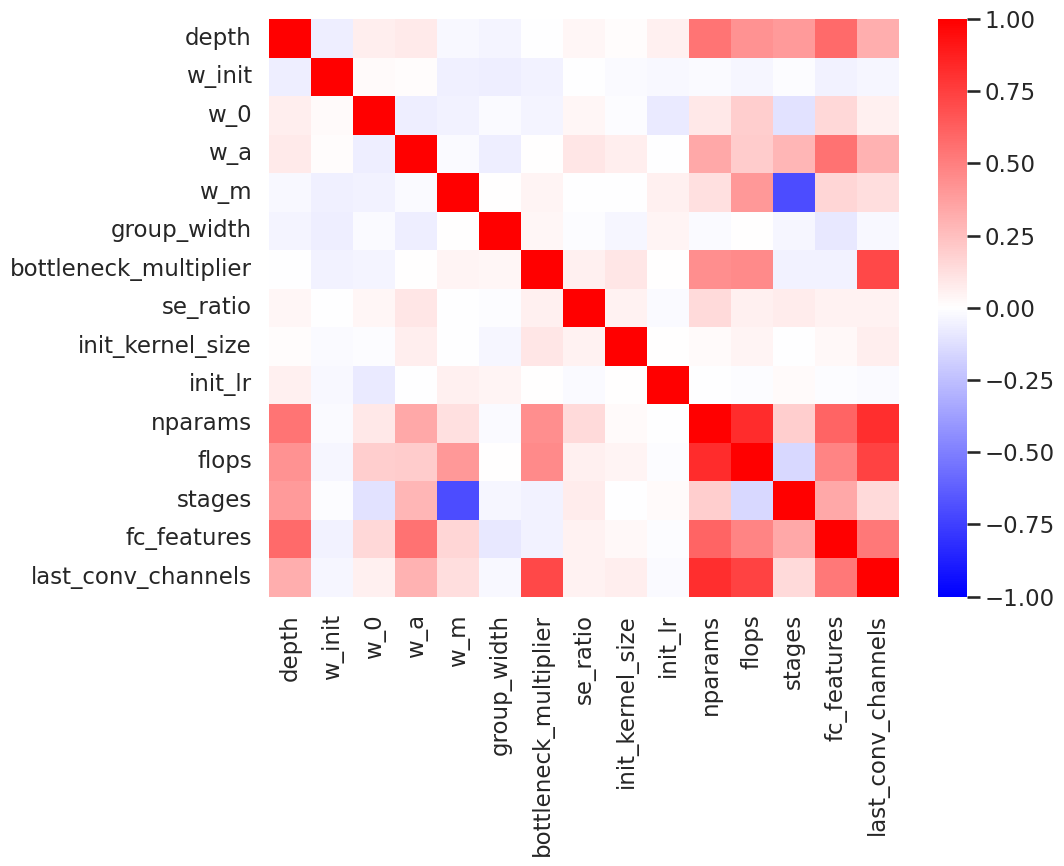

In [10]:
plt.figure(figsize=(11, 9))
sns.heatmap(res[HYPER_PARAMS].corr(), vmin=-1, vmax=1, cmap="bwr")
plt.tight_layout()
plt.savefig("./design_space_results/space_a/feature_corr.png", dpi=300)

In [11]:
def pareto_front(df, flops_col, perf_col, hue_col=None, hue_order=None, logx=True, save=False):
    """
    Generates a Pareto front plot to check if performance grows with FLOPs.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        flops_col (str): Column name for FLOPs.
        perf_col (str): Column name for performance.
        hue_col (str, optional): Column name for hue (to compute separate Pareto fronts per category).
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=flops_col, y=perf_col, hue=hue_col, hue_order=hue_order, alpha=0.5, legend=False)
    
    if hue_col:
        unique_hues = df[hue_col].unique()
        if hue_order:
            unique_hues = hue_order
    else:
        unique_hues = [None]
    
    for hue in unique_hues:
        subset = df if hue is None else df[df[hue_col] == hue]
        subset = subset.sort_values(by=flops_col)
        
        # Compute Pareto front (monotonically increasing performance)
        pareto_flops = []
        pareto_perf = []
        best_perf = -np.inf
        
        for _, row in subset.iterrows():
            flops, perf = row[flops_col], row[perf_col]
            if perf > best_perf:
                pareto_flops.append(flops)
                pareto_perf.append(perf)
                best_perf = perf
        
        # Plot Pareto front
        sns.lineplot(x=pareto_flops, y=pareto_perf, label=f"Pareto ({hue})" if hue is not None else "Pareto Front", marker="o")

    if logx:
        plt.xscale("log")
    plt.xlabel("FLOPs")
    plt.ylabel("Physio Accuracy")
    plt.legend()
    if save:
        plt.savefig(save, dpi=300)
    plt.show()

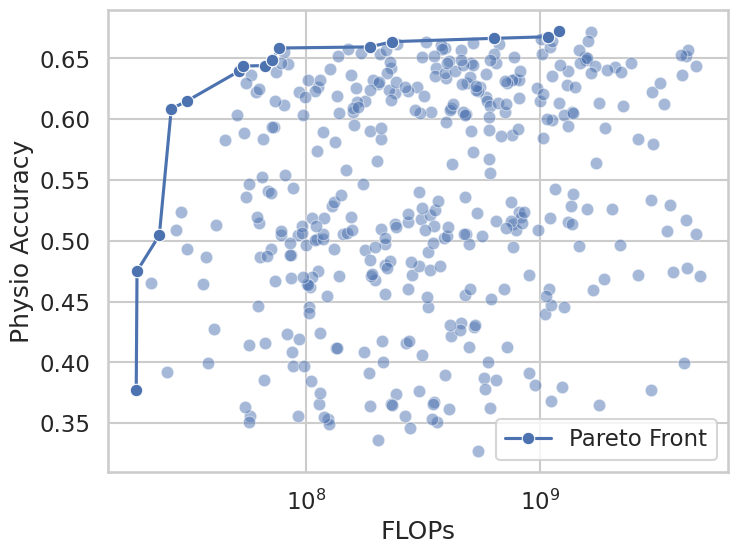

In [355]:
pareto_front(res, "flops", "PhysioAccuracy", save="./design_space_results/space_a/pareto.png")

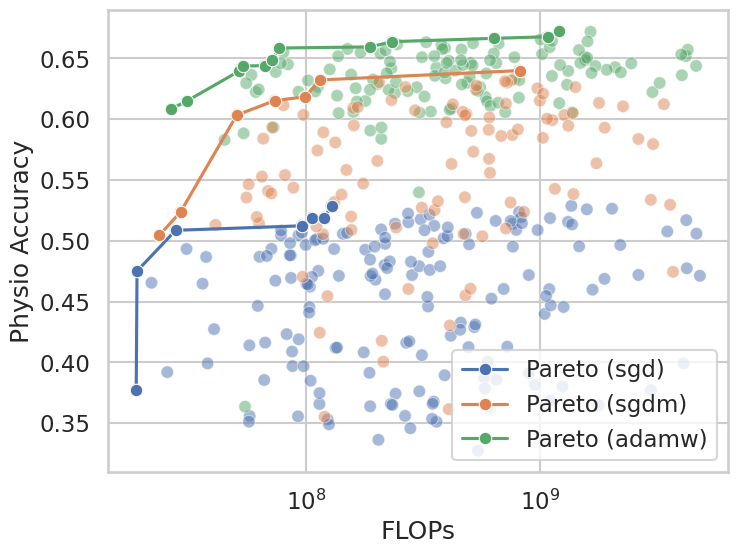

In [356]:
pareto_front(res, "flops", "PhysioAccuracy", "optimizer", hue_order=optim_hue_order, save="./design_space_results/space_a/pareto_optimizer.png")

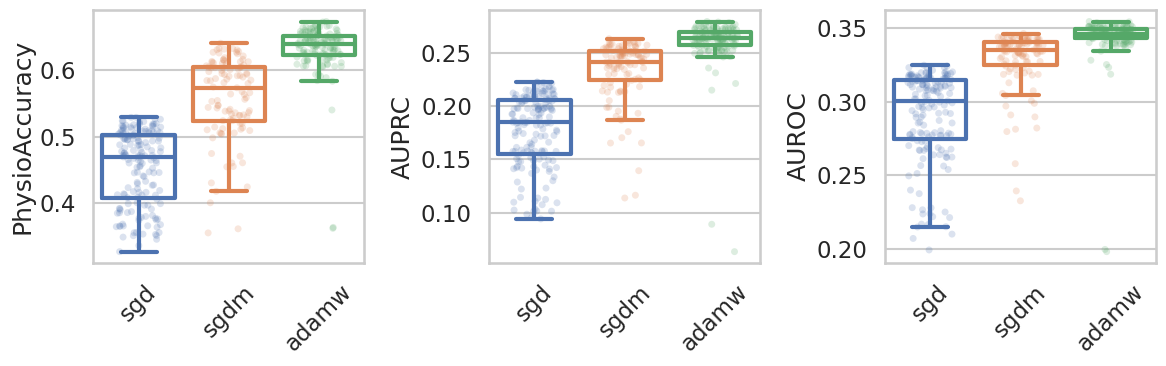

In [357]:
fig, axs = plt.subplots(1, 3, sharex=True)
fig.set_size_inches(12, 4)
for metric, ax in zip(METRICS[:3], axs.flatten()):
    sns.boxplot(res, x="optimizer", y=metric, ax=ax, zorder=2, hue="optimizer", hue_order=optim_hue_order, fliersize=0, linewidth=3, fill=False, order=optim_hue_order)
    sns.stripplot(res, x="optimizer", y=metric, ax=ax, zorder=3, alpha=0.2, jitter=0.25, hue="optimizer", hue_order=optim_hue_order,  order=optim_hue_order)
    ax.set_xlabel("")
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

In [12]:
def cross_valiade(X, y, splits=3):
    results = []
    for i, (train_idx, val_idx) in enumerate(KFold(n_splits=splits, shuffle=True).split(X, y)):
    
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
        gforest = GradientBoostingRegressor().fit(X_train, y_train)
        y_pred = gforest.predict(X_val)

        correlation = pearsonr(y_val, y_pred)
        
        results.append({"pearsonr": correlation.statistic, "significance": correlation.pvalue, "y_pred": y_pred, "y_true": y_val})
        
    return results

def feautre_importance(X, y):
    gforest = GradientBoostingRegressor().fit(X, y)
    explainer = shap.TreeExplainer(gforest)
    shap_values = explainer(X)

    feature_importance_dict = dict(sorted(zip(X.columns, gforest.feature_importances_), 
                                    key=lambda x: x[1], 
                                    reverse=True))
    
    return shap_values, feature_importance_dict, gforest

In [13]:
results = {}

   
y = res.PhysioAccuracy
X = res.loc[:, HYPER_PARAMS + ["optimizer"]]
X.optimizer = X.optimizer.map({"sgd": 0, "sgdm": 1, "adamw": 2})

X = X[~y.isna()]
y = y[~y.isna()]

shap_values, impurity, gforest = feautre_importance(X, y)

X_ = PCA(2).fit_transform(StandardScaler().fit_transform(X))
pca = PCA(14).fit(StandardScaler().fit_transform(X))

cross_validation = cross_valiade(X, y)

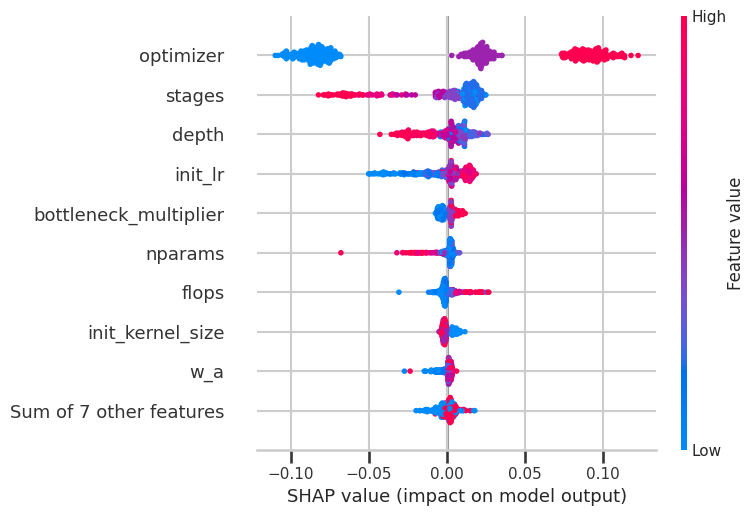

In [15]:
shap.plots.beeswarm(shap_values, show=False, max_display=10)
plt.tight_layout()
plt.savefig("./design_space_results/space_a/all_features_beeswarm.png", dpi=300)

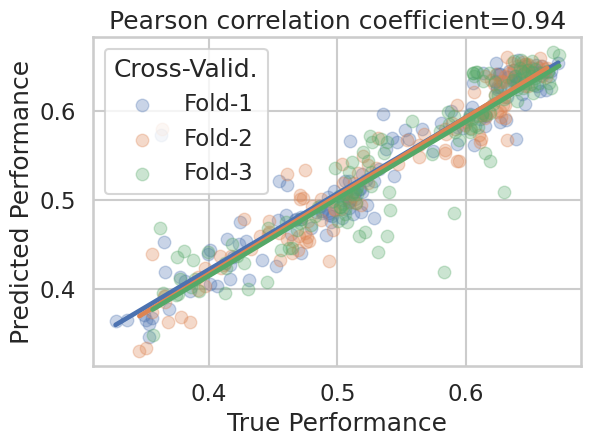

In [376]:
pea = np.mean([r["pearsonr"] for r in cross_validation])
# sig = np.mean([r["significance"] for r in cross_validation])
plt.title(f"Pearson correlation coefficient={pea:.2f}")
for i, cv in enumerate(cross_validation):
    sns.regplot(x=cv["y_true"], y=cv["y_pred"], label=f"Fold-{i+1}", scatter_kws=dict(alpha=0.3), ci=0)
plt.legend(title="Cross-Valid.")
plt.xlabel("True Performance")
plt.ylabel("Predicted Performance")
plt.tight_layout()
plt.savefig("./design_space_results/space_a/cross_validation_perforamnce.png", dpi=300)
plt.show()

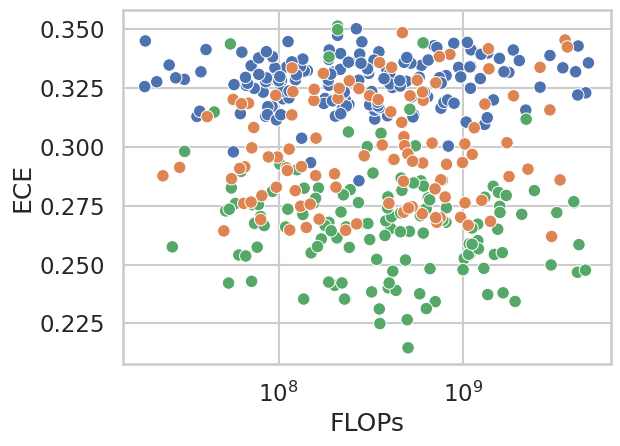

In [377]:
# plt.figure(figsize=(8, 6))
sns.scatterplot(res, x="flops", y="ECE", hue="optimizer", hue_order=optim_hue_order, legend=False)
plt.xscale("log")
plt.xlabel("FLOPs")
# plt.legend(loc=(1.01, 0.01))
plt.tight_layout()
plt.savefig("./design_space_results/space_a/ece_vs_flops.png", dpi=300)

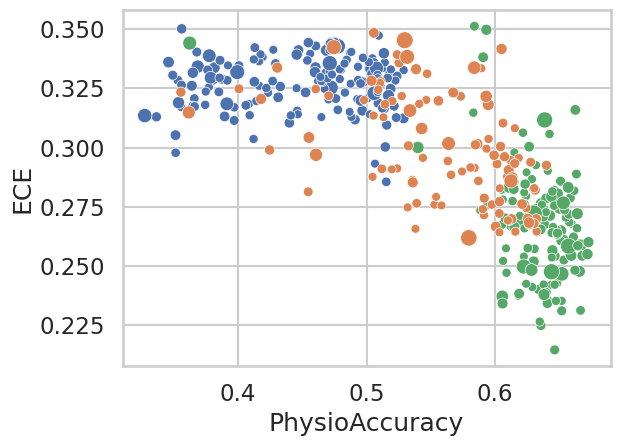

In [378]:
sns.scatterplot(res, x="PhysioAccuracy", y="ECE", hue="optimizer", hue_order=optim_hue_order, size="nparams", legend=False)
plt.tight_layout()
# plt.savefig("./design_space_results/space_a/ece_vs_performance.png", dpi=300)

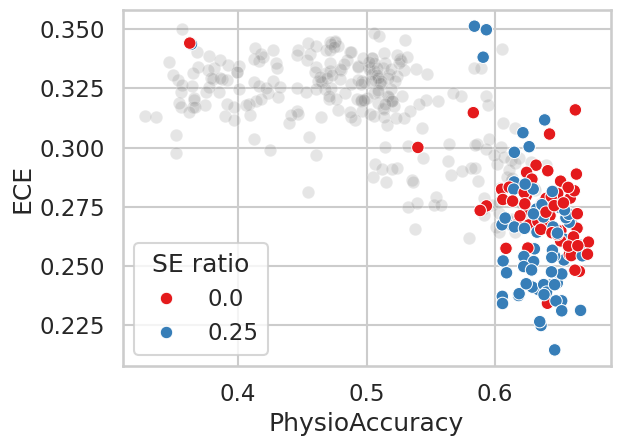

In [379]:
sns.scatterplot(res[res.optimizer != "adamw"], x="PhysioAccuracy", y="ECE", color="gray", alpha=0.2)
sns.scatterplot(res[res.optimizer == "adamw"], x="PhysioAccuracy", y="ECE", hue="se_ratio", palette="Set1")
plt.legend(title="SE ratio")
plt.tight_layout()
plt.savefig("./design_space_results/space_a/ece_vs_performance_vs_adam_se.png", dpi=300)

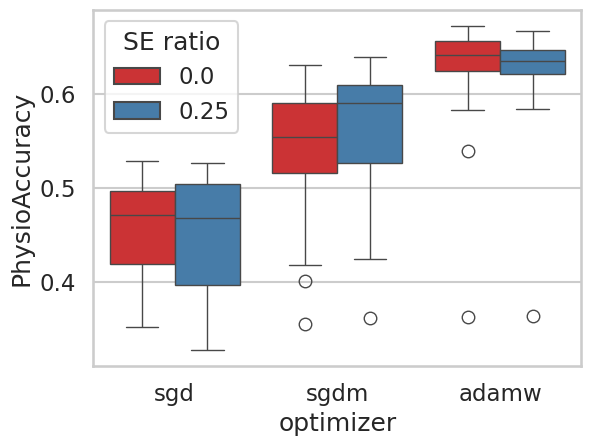

In [380]:
sns.boxplot(res, x="optimizer", y="PhysioAccuracy", hue="se_ratio", palette="Set1", order=["sgd", "sgdm", "adamw"])
plt.legend(title="SE ratio")
plt.tight_layout()
plt.savefig("./design_space_results/space_a/optim_vs_se_vs_performance.png", dpi=300)

## Optimizer specific

In [19]:
from scipy.stats import spearmanr

In [35]:
def get_correlattion(X, y):
    stats = spearmanr(X, y).statistic[:-1, -1]
    return dict(zip(X.columns, stats))

In [112]:
results = {}

for opt in ["sgd", "sgdm", "adamw"]:
    
    y = res[res.optimizer == opt].PhysioAccuracy
    X = res.loc[res.optimizer == opt, HYPER_PARAMS]
    X = X[~y.isna()]
    y = y[~y.isna()]

    shap_values, impurity, _ = feautre_importance(X, y)

    correlation = get_correlattion(X, y)

    X_ = PCA(2).fit_transform(StandardScaler().fit_transform(X))
    pca = PCA(14).fit(StandardScaler().fit_transform(X))

    results[opt] = {
        "cross_validation": cross_valiade(X, y),
        "shap_values": shap_values,
        "impurity": impurity,
        "correlation": correlation,
        "pca": X_,
        "explained_var": pca.explained_variance_ratio_.cumsum(),
        "y": y
    }


value_counts = res.optimizer.value_counts()

In [121]:
1024 * 0.5**4

64.0

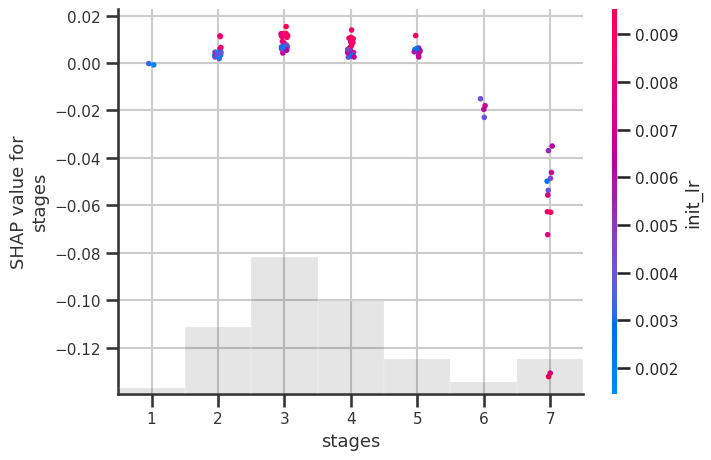

In [116]:
shap.plots.scatter(results["adamw"]["shap_values"][:, "stages"], color=results["adamw"]["shap_values"])

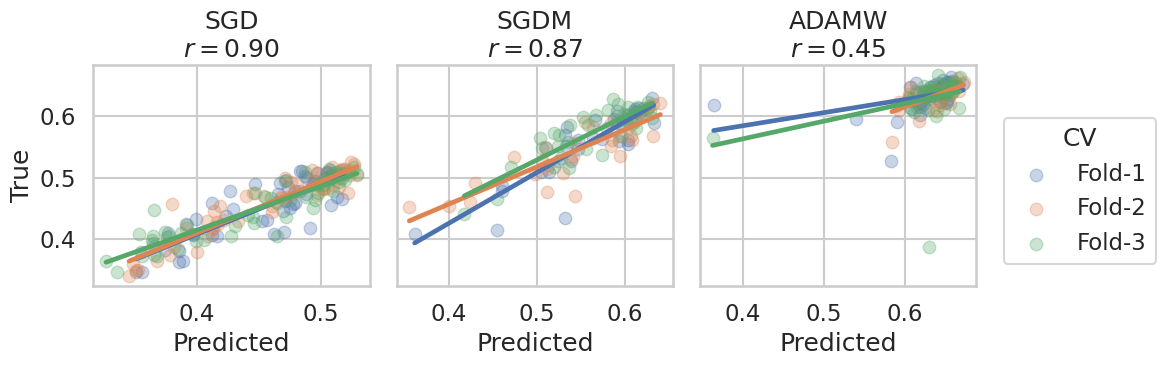

In [382]:
fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 4)

for ax, opt in zip(axs, ["sgd", "sgdm", "adamw"]):
    cv_result = results[opt]["cross_validation"]
    pea = np.mean([r["pearsonr"] for r in cv_result])
    sig = np.mean([r["significance"] for r in cv_result])
   
    for i, r in enumerate(cv_result):
        sns.regplot(x=r["y_true"], y=r["y_pred"], label=f"Fold-{i+1}", scatter_kws=dict(alpha=0.3), ci=0, ax=ax)
    ax.set_title(f"{opt.upper()}\n$r={pea:.2f}$")
    ax.set_xlabel("Predicted")
    if opt == "sgd":
        ax.set_ylabel("True")
plt.legend(title="CV", loc=(1.1, 0.1))
plt.tight_layout()
plt.savefig("./design_space_results/space_a/cross_validation_vs_optimizer.png", dpi=300)
plt.show()

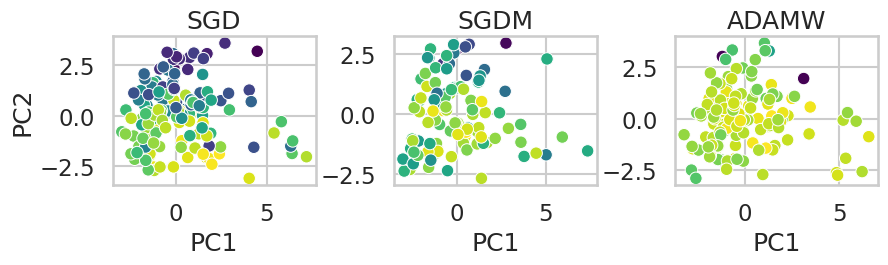

In [383]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

for ax, opt in zip(axs, ["sgd", "sgdm", "adamw"]):
    sns.scatterplot(x=results[opt]["pca"][:, 0], y=results[opt]["pca"][:, 1], hue=results[opt]["y"], ax=ax, palette="viridis", legend=False)
    ax.set_xlabel("PC1")
    if opt == "sgd":
        ax.set_ylabel("PC2")
    ax.set_title(opt.upper())
    # ax[1].plot(results[opt]["explained_var"], lw=5, color="black")
    # ax[1].set_ylim(0, 1)
    # ax[1].set_xlabel("# Features")
    # ax[1].grid()
    # if opt == "sgd":
    #     ax[1].set_ylabel("Cummulative explained variance")   
plt.tight_layout()
plt.show()

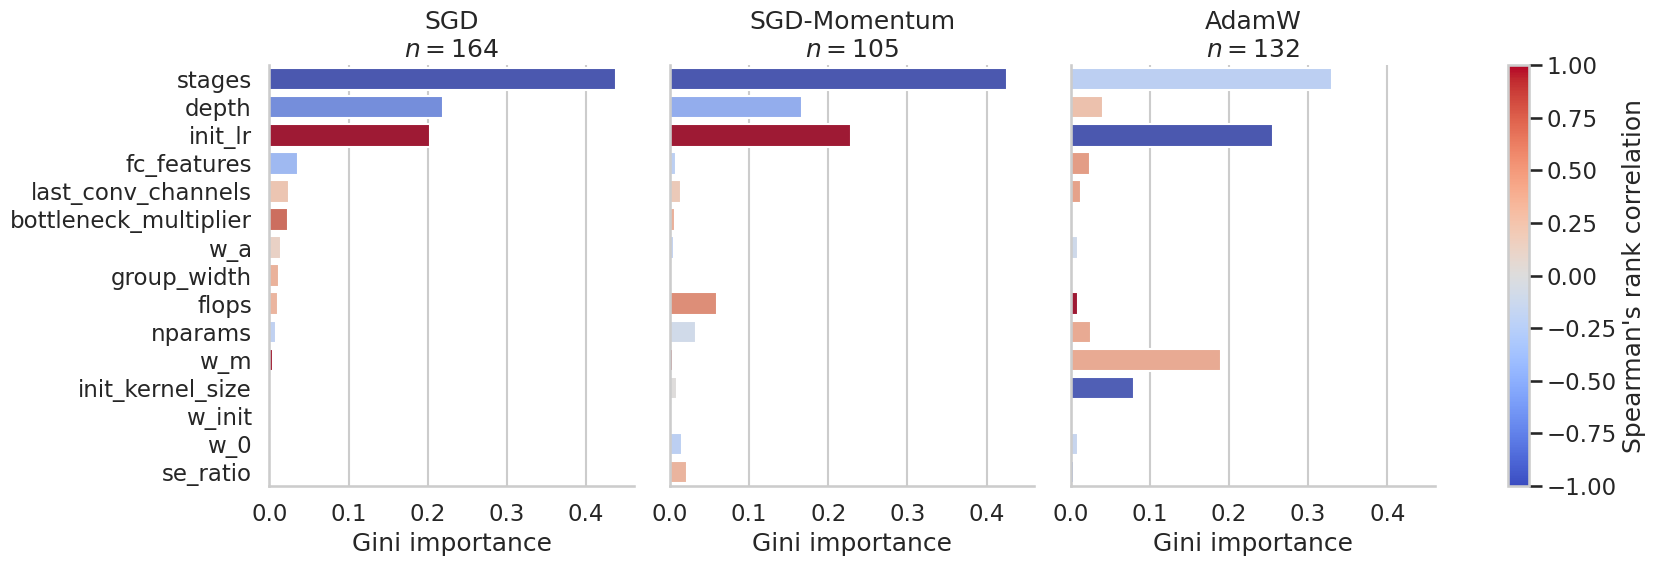

In [110]:
from matplotlib.colors import Normalize

t = {
    "sgd": "SGD",
    "sgdm": "SGD-Momentum",
    "adamw": "AdamW",
}

r = []
for opt, val in results.items():
    for key, imp in val["impurity"].items():
        corr = val["correlation"][key]
        r.append((f"{t[opt]}\n$n={value_counts[opt]}$", key, corr, imp))
df = pd.DataFrame(r, columns=["Optimizer", "Parameter", "Correlation", "Impurity"])

g = sns.FacetGrid(df, col="Optimizer", height=6)
g.map_dataframe(sns.barplot, x="Impurity", y="Parameter", hue="Correlation", palette="coolwarm", legend=False)
g.set_xlabels("Gini importance")
g.set_ylabels("")
g.set_titles(col_template="{col_name}")

norm = Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
g.fig.colorbar(sm, ax=g.axes.ravel().tolist(), label="Spearman's rank correlation")
plt.savefig("./design_space_results/space_a/feature_impurity.png", dpi=300)

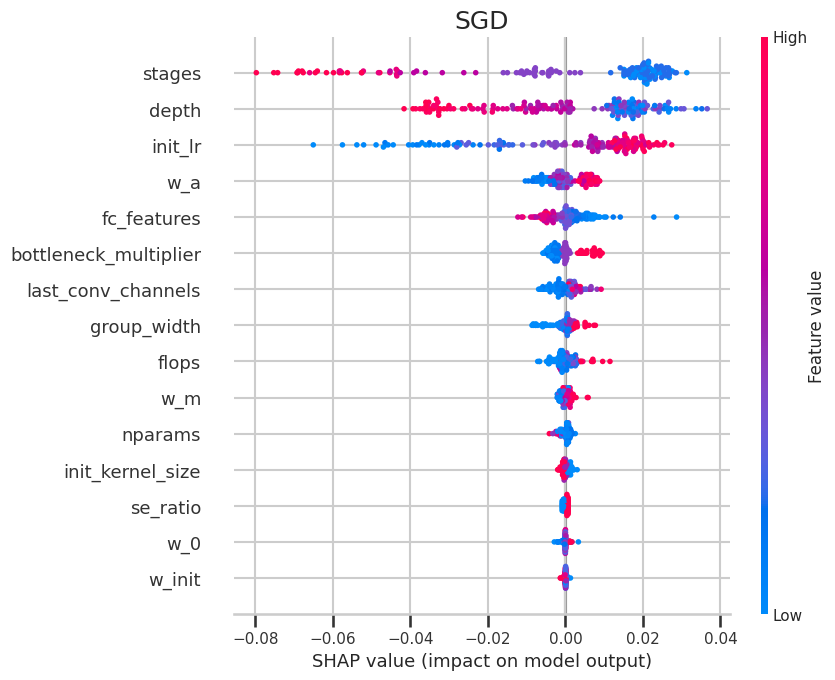

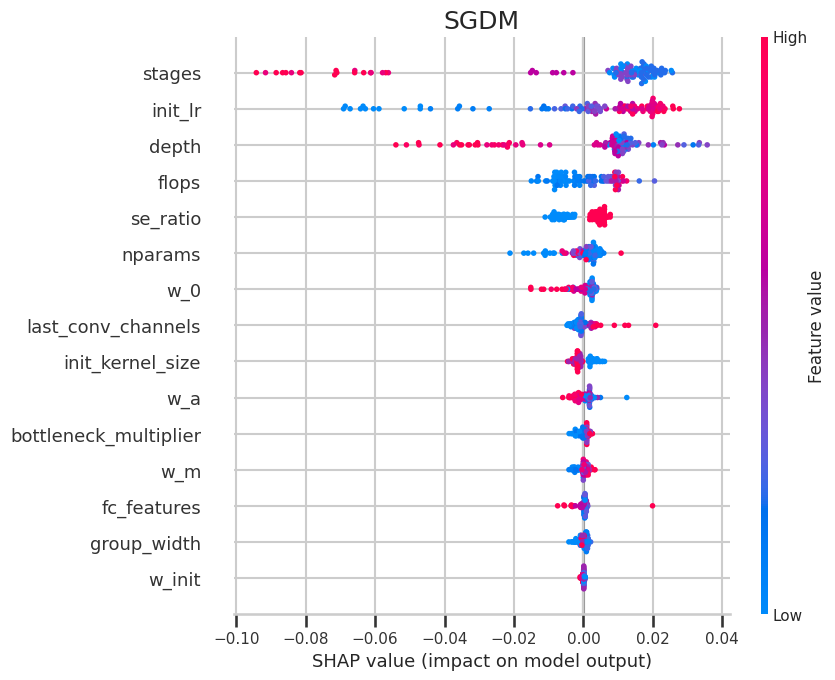

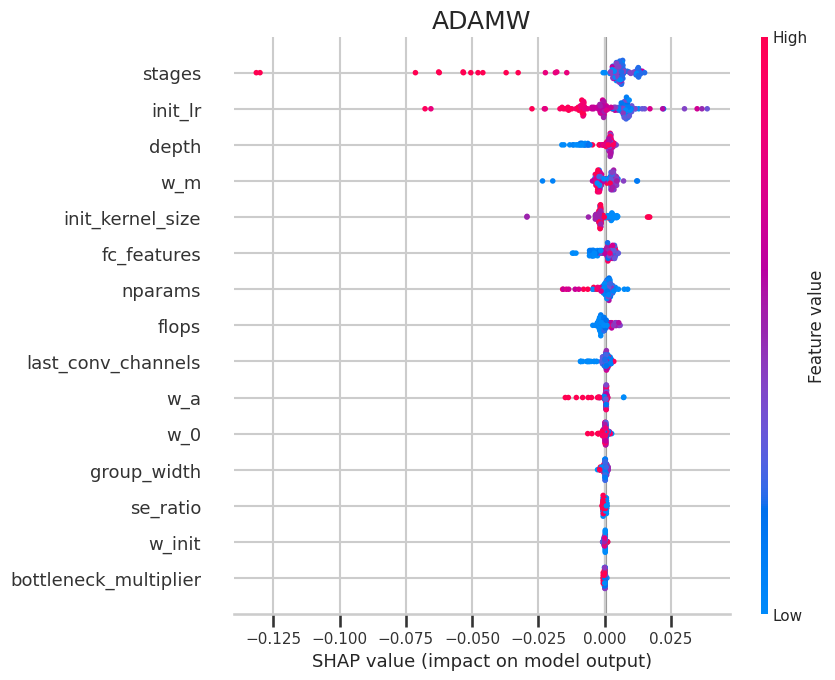

In [385]:
for i, opt in enumerate(["sgd", "sgdm", "adamw"]):
    shap_values = results[opt]["shap_values"]
    plt.title(opt.upper())
    shap.plots.beeswarm(shap_values, show=False, max_display=15)
    plt.savefig(f"./design_space_results/space_a/shap_beeswarm_{opt}.png", dpi=300)
    plt.show()

## Explaining the best AdamW models

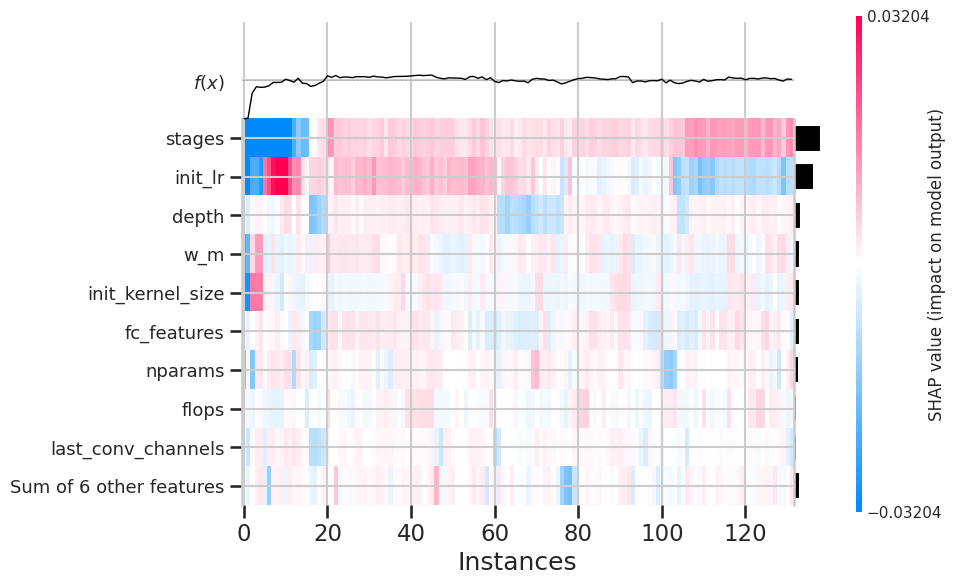

<Axes: xlabel='Instances'>

In [447]:
shap.plots.heatmap(results["adamw"]["shap_values"])

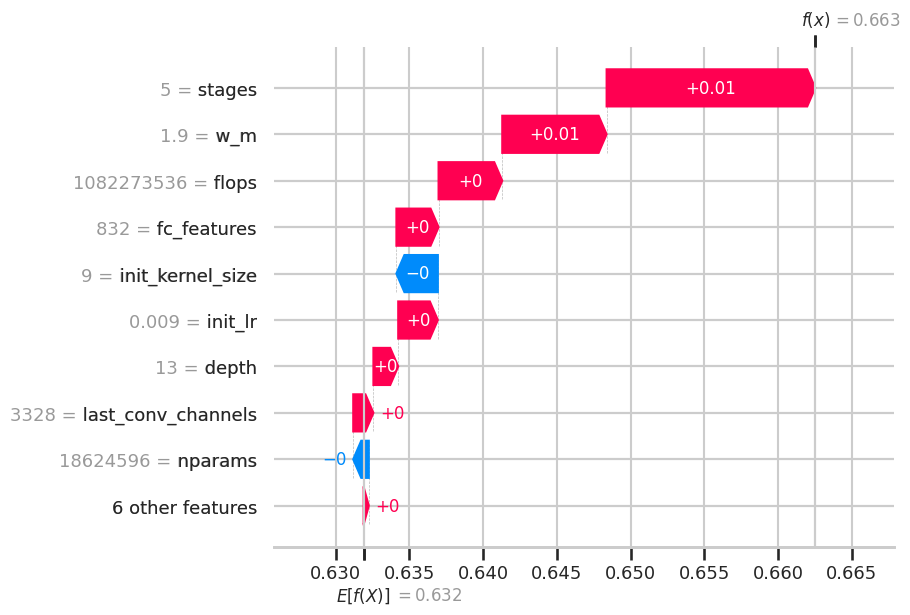

In [446]:
idx = y.reset_index(drop=True).sort_values(ascending=False).index[3]
shap.plots.waterfall(results["adamw"]["shap_values"][idx])

# Design space B

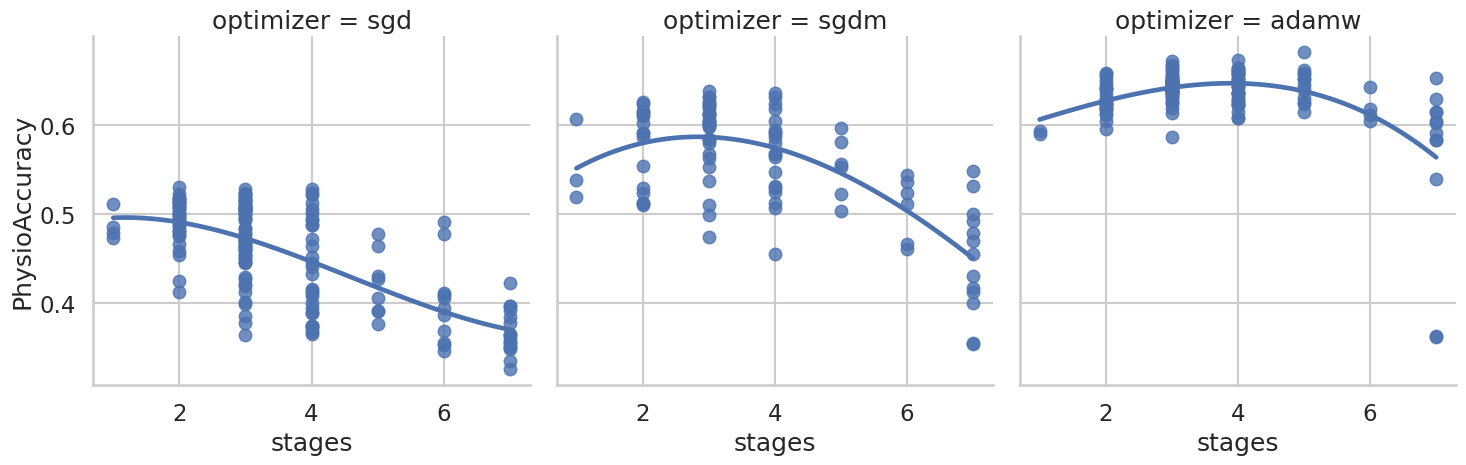

In [671]:
sns.lmplot(res, x="stages", y="PhysioAccuracy", col="optimizer", col_order=optim_hue_order, order=3, ci=0)
plt.tight_layout()
plt.savefig("./design_space_results/space_a/optim_vs_stages_vs_performance.png", dpi=300)
plt.show()

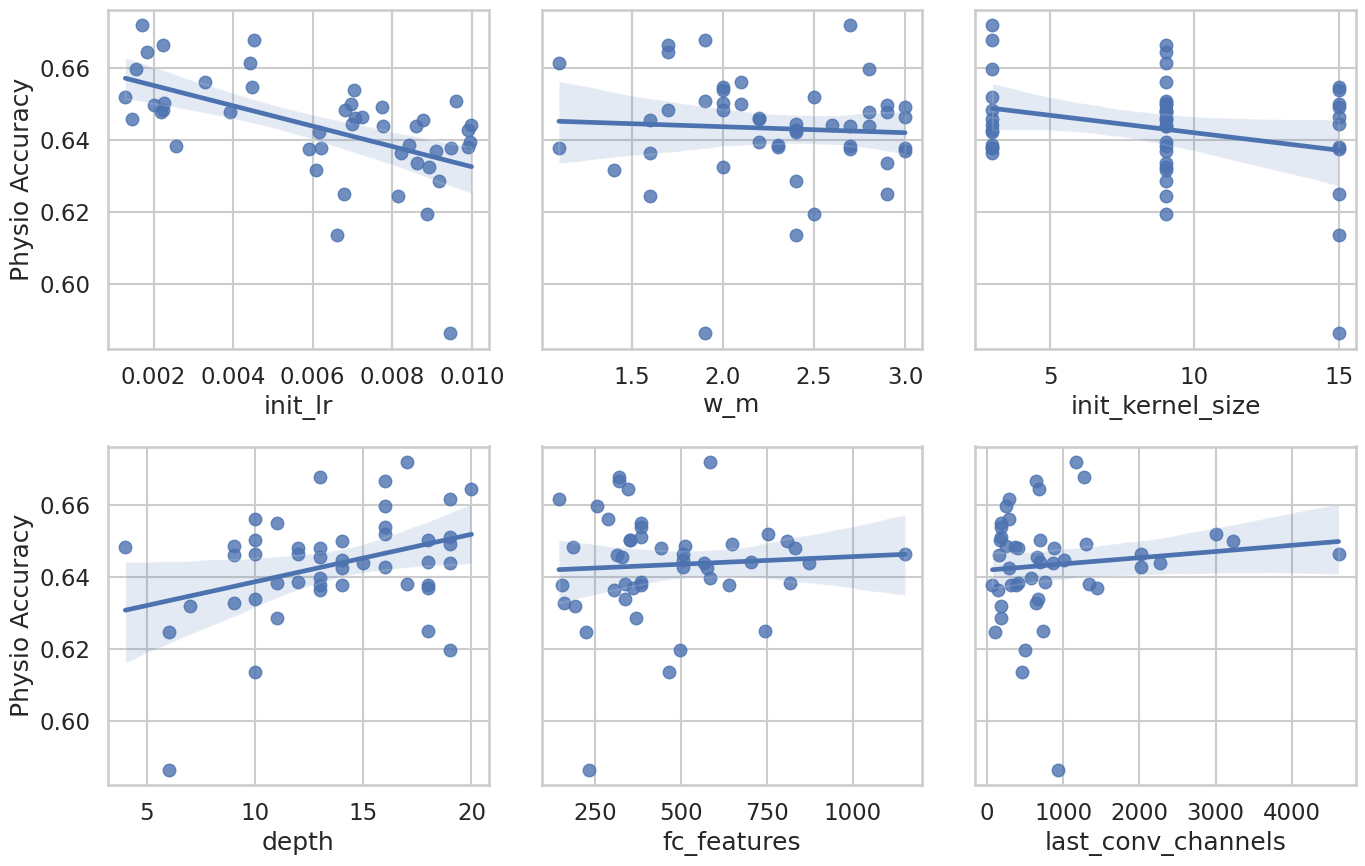

In [681]:
fig, axs = plt.subplots(2, 3, figsize=(14, 9), sharey=True)
features = ['init_lr', 'w_m', 'init_kernel_size', 'depth', 'fc_features', "last_conv_channels"]
for i, (ax, feature) in enumerate(zip(axs.flatten(), features)):
    sns.regplot(res[(res.optimizer == "adamw") & (res.stages == 3)], x=feature, y="PhysioAccuracy", ax=ax)
    ylabel = "Physio Accuracy" if i % 3 == 0 else ""
    ax.set_ylabel(ylabel)
plt.tight_layout()
plt.savefig("./design_space_results/space_a/design_design_space_b_low_flop.png", dpi=300)
plt.show()

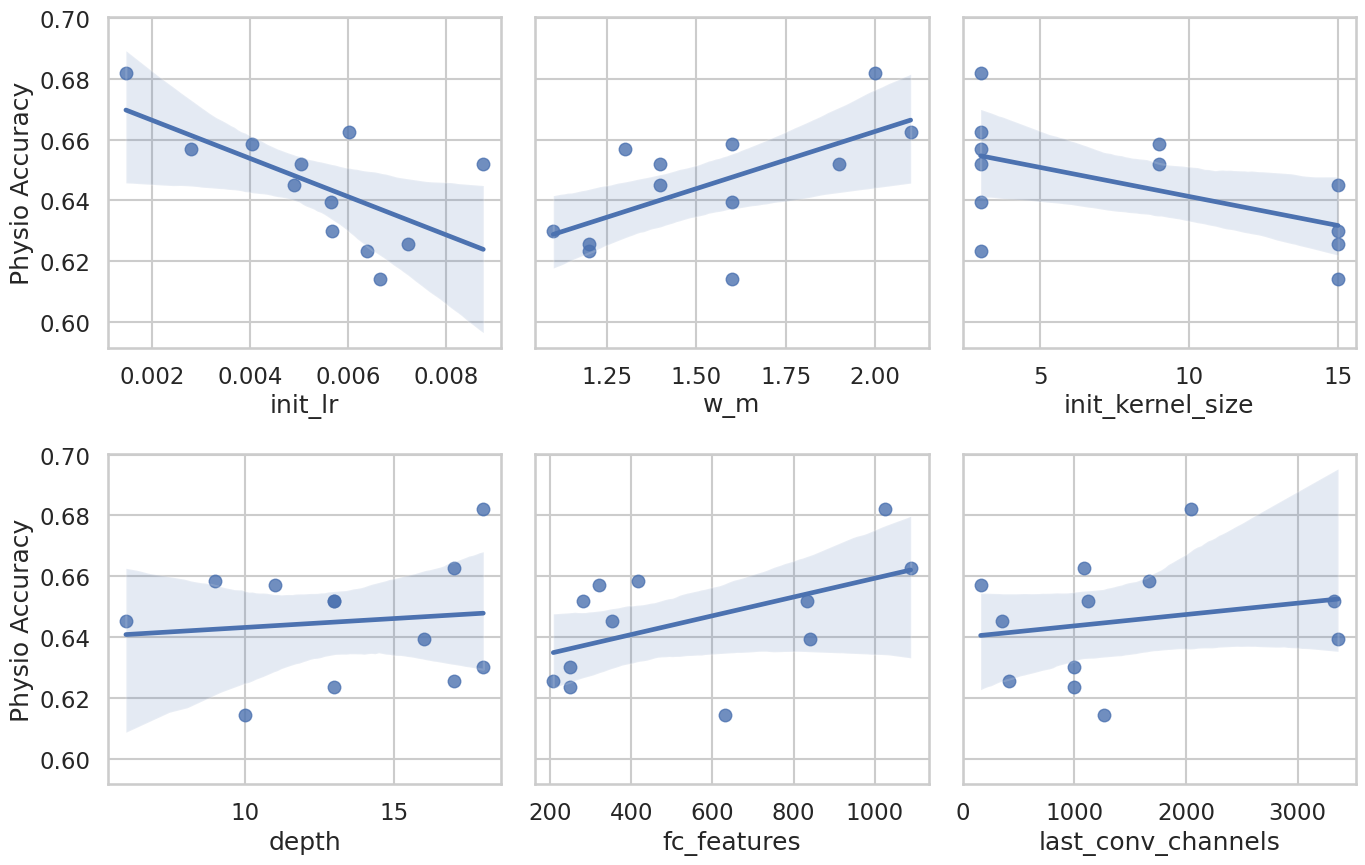

In [682]:
fig, axs = plt.subplots(2, 3, figsize=(14, 9), sharey=True)
features = ['init_lr', 'w_m', 'init_kernel_size', 'depth', 'fc_features', "last_conv_channels"]
for i, (ax, feature) in enumerate(zip(axs.flatten(), features)):
    sns.regplot(res[(res.optimizer == "adamw") & (res.stages == 5)], x=feature, y="PhysioAccuracy", ax=ax)
    ylabel = "Physio Accuracy" if i % 3 == 0 else ""
    ax.set_ylabel(ylabel)
plt.tight_layout()
plt.savefig("./design_space_results/space_a/design_design_space_b_high_flop.png", dpi=300)
plt.show()

In [644]:
def get_best_per_optim(df):
    return df.loc[df.groupby("optimizer").idxmax().PhysioAccuracy.values, HYPER_PARAMS + ["optimizer", "PhysioAccuracy"]]

In [645]:
high_flop_regime = res[res.flops > 10**7].reset_index()
low_flop_regime = res[res.flops < 10**7].reset_index()

In [646]:
get_best_per_optim(res)

,depth,w_init,w_0,w_a,w_m,group_width,bottleneck_multiplier,se_ratio,init_kernel_size,init_lr,nparams,flops,stages,fc_features,last_conv_channels,optimizer,PhysioAccuracy
198,18,64,64,40,2.0,4,2.0,0.00,3,0.001464,14676378,29199872,5,1024,2048,adamw,0.681977
88,11,32,128,17,2.6,32,4.0,0.25,15,0.008337,8241446,16362816,2,336,1344,sgd,0.530758
368,11,64,88,32,2.6,8,2.0,0.25,3,0.007078,5082720,10088640,3,592,1184,sgdm,0.638894


In [418]:
get_best_per_optim(high_flop_regime)

,depth,w_init,w_0,w_a,w_m,group_width,bottleneck_multiplier,se_ratio,init_kernel_size,init_lr,nparams,stages,fc_features,last_conv_channels,optimizer,PhysioAccuracy
56,18,64,64,40,2.0,4,2.0,0.00,3,0.001464,14676378,5,1024,2048,adamw,0.681977
21,11,32,128,17,2.6,32,4.0,0.25,15,0.008337,8241446,2,336,1344,sgd,0.530758
118,11,64,88,32,2.6,8,2.0,0.25,3,0.007078,5082720,3,592,1184,sgdm,0.638894


In [419]:
get_best_per_optim(low_flop_regime)

,depth,w_init,w_0,w_a,w_m,group_width,bottleneck_multiplier,se_ratio,init_kernel_size,init_lr,nparams,stages,fc_features,last_conv_channels,optimizer,PhysioAccuracy
172,16,48,112,10,1.7,4,2.0,0.25,9,0.002232,3139782,3,320,640,adamw,0.666575
24,15,32,56,19,1.1,4,4.0,0.00,3,0.009242,1436154,4,112,448,sgd,0.528836
208,6,40,40,29,1.8,1,4.0,0.25,15,0.009650,978560,4,232,928,sgdm,0.635793
